# Plots for Data analysis
What is in this script?
Plots for Fig 1, 2, and 3 of paper.
Plus supplemental plots 1-3

What is not in this script?
All intensity traces from example cells can be found in the script 'Plotted_examples_intensitytraces.py'. It is not included in this script to ensure that the example movies come from the same data set/cell as the plots.

In [1]:
# packages
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import seaborn as sns
from scipy import stats
from skimage.morphology import remove_small_holes
import statsmodels.api as sm
import itertools
from glob import glob

#define some global setting for aesthetics
#default to overwrite sns settings
plt.style.use('default')
# set text to arial
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# set font size in pt
font = {'size': 6}
matplotlib.rc('font', **font)

# conversion factor from mm to inch (matplotlib uses inch)
mm = 1 / 25.4

#functions for data processing
def remove_zero_text(x):
    """"
    Remove the zero from the clone name, e.g. 6G03 -> 6G3
    Args:
         x: (str) clone name
    Returns:
         x: (str) clone name without zero
    """
    if len(x) >= 3 and x[2] == '0':
        return x[:2] + x[3:]
    else:
        return x


def signallength(x, column):
    """
    From a series calculate how long a state was present, including information about GFP levels.
    Args:
         x: (pd.Dataframe) dataframe in which one column should be processed
         column: (str) column name from x to be processed
    Returns:
         burst_stats: (pd.Dataframe) processed dataframe
    """
    x = x.assign(signal_no=(x[column] != x[column].shift()).cumsum())
    burst_stats = x.groupby(['unique_id', 'signal_no', column]).agg(
        {'frame': ['count'], 'corr_trace': ['sum', 'max'],
         'integrated_intensity_gfp': ['sum', 'max']}).reset_index()
    burst_stats.columns = list(map(''.join, burst_stats.columns.values))
    return burst_stats


def indicate_first_last(x, column):
    """
    From a series, indicate the if the occurrence is left-, right-, non-censored or both, right and left censored.
    Args:
         x: (pd.Dataframe) dataframe in which one column should be processed
         column: (str) column name from x to be processed
    Returns:
         data: (pd.Dataframe) processed dataframe with an additional column containing the censoring information
    """
    data = x.copy()
    data['censored'] = 'noncensored'
    min_id = data[column].min()
    max_id = data[column].max()
    data.loc[data[column] == min_id, 'censored'] = 'leftcensored'
    data.loc[data[column] == max_id, 'censored'] = 'rightcensored'
    if min_id == max_id:
        data['censored'] = 'nonbursting'
    return data


def remove_positives(data, area_size=2):
    """
    From a bool signal trace, removes True values of certain length
    Args:
         data: (pd.Series) data trace to be processed
         area_size: (int) minimal length of consecutive True values to keep

    Returns:
         data_array_filtered: (pd.Series) filtered data trace
    """
    data_array = data.apply(lambda x: not x)
    data_array_filtered = remove_small_holes(data_array, area_threshold=area_size)
    data_array_filtered = ~data_array_filtered.astype(bool)
    return data_array_filtered

In [2]:
# Global variables
# where to save the plots
path_out = '/Users/janatunnermann/Desktop/plots_paper/'

# color scheme
green_5e10 = (111 / 255, 188 / 255, 133 / 255)
blue_5f11 = (113 / 255, 171 / 255, 221 / 255)
purple_5g3 = (156 / 255, 107 / 255, 184 / 255)
red_5g7 = (213 / 255, 87 / 255, 69 / 255)
colors_clones_fit = [green_5e10, blue_5f11, purple_5g3, red_5g7]
clones_fit = ['5E10', '5F11', '5G3', '5G7']

#add info for 6G3, not bursting in black
colors_clones_all = pd.DataFrame({'clone': ['6G3'] + clones_fit, 'color': ['black'] + colors_clones_fit})

# Data loading
possible to load datasets independently, comments tell for which figures dataset is necessary

In [3]:
# Splinkerette Data (used in almost all figures, always loaded)
positions = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/Splinkerette/summary_output/Positions_plate5.6_withcontactprob.csv'
df_positions = pd.read_csv(positions)
df_positions['clone'] = df_positions['clone'].apply(remove_zero_text)
df_positions.rename(columns={'cp_distance': 'cp'}, inplace=True)

In [4]:
trendline = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/trendline_zuinetal.csv'
df_trendline = pd.read_csv(trendline, header=None)

In [6]:
# FACS data. for Fig 1, 2, 3
# read from Plate
FACS_data_plate = path = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/facs/analysis/MobiPlates5.6/analysis/SummaryFACS_Mobiplate56.csv'
df_facs_plate = pd.read_csv(FACS_data_plate)
df_facs_plate['clone'] = df_facs_plate['clone'].apply(remove_zero_text)
df_facs_plate.set_index('clone', inplace=True)

#add info about distance and contact probability from Splinkerette data
df_facs_plate = df_facs_plate.merge(df_positions[['clone', 'distance', 'cp']], on='clone')

# measured in parallel to live-imaging
FACS_data_exp = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/facs/analysis/livecell_fiveclones/imaging_day/ficeclone-liveimaging_gfp-flowcytomery_summary.csv'
df_facs_exp = pd.read_csv(FACS_data_exp, dtype={'Clone': 'str'})

In [5]:
# FISH data. for Fig 1, 2, 3
# average numbers per cell
FISH_data = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/fish/summarized_data/spots-per-cell-avg_MS2.csv'
df_fish_avgcell = pd.read_csv(FISH_data)

# individual spots per cell, has info if TSS or single molecule
FISH_data_individualspots = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/fish/summarized_data/individual_spots-per-cell_MS2_zscore_TS.csv'
df_fish_TS = pd.read_csv(FISH_data_individualspots)

In [6]:
# Groundtruth data from smFISH for TSS analysis plots (supplement 3)
# load threshold data
fishtreshold_data = pd.read_csv(
    '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/fish/summarized_data/bootstrap-results_thresholds_TS-classification.csv')
mu_tss = \
    fishtreshold_data.loc[fishtreshold_data['candidate'] == 'zscore_sample-data_spot_max_sub_shifted_log', 'mu'].values[
        0]
sigma_tss = \
    fishtreshold_data.loc[
        fishtreshold_data['candidate'] == 'zscore_sample-data_spot_max_sub_shifted_log', 'sigma'].values[
        0]
x_tss = np.linspace(mu_tss - 3 * sigma_tss, mu_tss + 3 * sigma_tss, 100)

# load groundtruth data (it includes data from cells that were excluded for analysis)
# import data
input_dir_singlemRNA = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/fish/data/output/groundtruth'
files_groundtruth = glob(os.path.join(input_dir_singlemRNA, "*_single-mRNA.csv"))
df_single = []
for file in files_groundtruth:
    df_file = pd.read_csv(file)
    df_file['file'] = os.path.basename(file)
    df_single.append(df_file)
df_single = pd.concat(df_single).reset_index(drop=True)

# clean-up column names
df_single.rename(columns={'axis-0': 'z', 'axis-1': 'y', 'axis-2': 'x'}, inplace=True)
df_single['file'] = df_single['file'].str.replace('_single-mRNA', '_postprocessed')
df_single['TS_groundtruth'] = 'singlemRNA'
df_single.drop(columns=['index'], inplace=True)
df_single = df_single.dropna().reset_index(drop=True)

# include spot intensity information from ms2 data
files = np.unique(df_single['file'])
df_fish_TS_groundtruth = df_fish_TS[df_fish_TS['file'].isin(files)][['file', 'z', 'y', 'x', 'zscore']].dropna()
df_fish_TS_groundtruth = df_fish_TS_groundtruth.merge(df_single, on=['file', 'z', 'y', 'x'], how='left', indicator=True)
df_fish_TS_groundtruth['TS_groundtruth'] = df_fish_TS_groundtruth['TS_groundtruth'].fillna('TS')
df_fish_TS_groundtruth.drop(columns=['_merge'], inplace=True)

In [8]:
# Live-cell data. for Fig 1, 2, 3
live_imaging = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/live_imaging/data/306KI-ddCTCF-dpuro-MS2-HaloMCP-E10Mobi_JF549_30s_fiveclone_combined_threshold2800_curated.csv'
df_burst = pd.read_csv(live_imaging, dtype={'clone': 'str'}, low_memory=False)
# exclude first hour of imaging
df_burst = df_burst[df_burst['frame'] >= 120]
df_burst = df_burst[df_burst['frame'] <= 600]
# exclude a few outlier cells that I manually marked
df_burst = df_burst[df_burst['spotdetected_filtered_curated'].notna()]
# calculate if a cell was bursting or not
datatype = 'spotdetected_filtered_curated'
bursting = df_burst.groupby(['unique_id']).apply(lambda x: x[datatype].any()).reset_index()
bursting.columns = ['unique_id', 'bursting']
df_burst = df_burst.merge(bursting, on='unique_id')
df_burst.groupby('clone')['unique_id'].nunique()
# info about distance and contact probability from Splinkerette data
df_burst = df_burst.merge(df_positions[['clone', 'distance', 'cp']], on='clone')

# Data pre-processing

In [9]:
# Live-cell imaging data, calculate event length and intensity for (aka on-/off-times)
# is used for KM and Survival Probabilities and Burst frequency

# Calculate stats including edge-cases (censored data) -> KM
# sum-up length of states
df_signallength = [signallength(df_burst[df_burst['unique_id'] == i], column=datatype) for i in
                   df_burst['unique_id'].unique()]
df_signallength = pd.concat(df_signallength, ignore_index=True)
df_signallength['clone'] = df_signallength['unique_id'].map(df_burst.groupby(['unique_id'])['clone'].first())

# Indicate which values are incomplete/censored
df_signallength = [indicate_first_last(df_signallength[df_signallength['unique_id'] == i], column='signal_no') for i in
                   df_signallength['unique_id'].unique()]
df_signallength = pd.concat(df_signallength, ignore_index=True)

# decide on which data to use for KM
# drop left censored
df_signallength_KM = df_signallength[df_signallength.censored != 'leftcensored']
# keep right censored and non-censored
df_signallength_KM.loc[df_signallength_KM['censored'] == 'rightcensored', 'censored'] = 0
df_signallength_KM.loc[df_signallength_KM['censored'] == 'noncensored', 'censored'] = 1
# Either drop non bursting
df_signallength_KM = df_signallength_KM[df_signallength_KM.censored != 'nonbursting']


# decide on which data to use for Burst size and Burst amplitude
# drop left, right censored and non bursting
df_signallength_dropedge = df_signallength[df_signallength.censored != 'leftcensored']
df_signallength_dropedge = df_signallength_dropedge[df_signallength_dropedge.censored != 'rightcensored']
df_signallength_dropedge = df_signallength_dropedge[df_signallength_dropedge.censored != 'nonbursting']

# Figure 1
Intensity trace and cell cut outs can be plotted with a different script: 'Plotted_examples_intensitytraces.py'

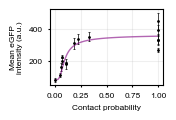

In [10]:
# --- Flow cytometry with Jessica's trend-line ---
# scale trend-line to min and max value from my experiment (maybe fit instead?)
df_trendline_scaled = df_trendline.copy()
# Define the minimum and maximum values for scaling
min_value, min_cp = df_facs_plate.loc[df_facs_plate['clone'] == '6G3', ['Mean', 'cp']].values[0]
max_cp = 1
max_value = df_facs_plate.loc[df_facs_plate['cp'] == max_cp, ['Mean']].mean().values[0]
# Extract the original y values corresponding to x1 and x2
min_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0, df_trendline_scaled.columns[1]].values[0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]

# Calculate slope (m) and intercept (b)
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original

# Apply the linear transformation to the entire y column
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b

plt.figure(figsize=(40*mm, 26*mm))
plt.errorbar(df_facs_plate['cp'], df_facs_plate['Mean'], yerr=df_facs_plate['SD'], fmt="o", color='black', markersize=1,
             capsize=1,
             capthick=0.5,
             elinewidth=0.5)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', alpha=0.6, linewidth=1)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.xlabel('Contact probability')
plt.ylabel('Mean EGFP\nintensity (a.u.)')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'GFP_facs_trendline.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

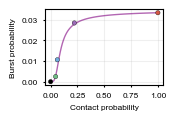

In [11]:
# burst probability per frame and average
df_probability = df_burst.groupby(['clone', 'frame']).agg({'spotdetected_filtered_curated': 'mean'}).reset_index()
df_probability = df_probability.groupby('clone').agg({'spotdetected_filtered_curated': 'mean'}).reset_index()
df_probability = df_probability.merge(df_positions[['clone', 'distance', 'cp']], on='clone')
df_probability = df_probability.merge(colors_clones_all)

# scale trend-line to min and max value from my experiment (maybe fit instead?)
df_trendline_scaled = df_trendline.copy()
min_value, min_cp = \
    df_probability.loc[df_probability['clone'] == '6G3', ['spotdetected_filtered_curated', 'cp']].values[0]
max_value, max_cp = \
    df_probability.loc[df_probability['clone'] == '5G7', ['spotdetected_filtered_curated', 'cp']].values[0]
min_original = \
    df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == round(min_cp, 2), df_trendline_scaled.columns[1]].values[
        0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b


plt.figure(figsize=(40*mm, 26*mm))
plt.scatter(df_probability['cp'], df_probability['spotdetected_filtered_curated'], color=df_probability['color'], edgecolor ='black', linewidths=0.25, zorder=3, s=10)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', linewidth=1, alpha=0.6, zorder=2)
plt.grid(alpha=0.2, zorder=1)
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.tick_params(axis='both', which='both', length=1.5)
plt.xlabel('Contact probability')
plt.ylabel('Burst probability')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'probability_bursting_trendline_colored.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Supplements 1

/var/folders/xw/97j8jgvs0jj4vght5r2xkt1h0000gp/T/ipykernel_29278/3634608825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_facs_plate_tad['distance'] = df_facs_plate_tad['distance'] / 1000


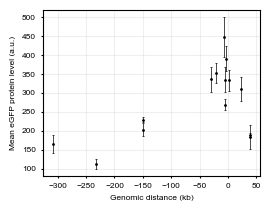

In [13]:
# --- Flow cytometry and genomic distance ---
# exclude 6G3, it's on another chromosome/too far to be plotted
df_facs_plate_tad = df_facs_plate[df_facs_plate['clone'] != '6G3']
df_facs_plate_tad['distance'] = df_facs_plate_tad['distance'] / 1000

plt.figure(figsize=(64*mm, 49*mm))
plt.errorbar(df_facs_plate_tad['distance'], df_facs_plate_tad['Mean'], yerr=df_facs_plate_tad['SD'], fmt="o",
             color='black', markersize=1,
             capsize=1,  # Size of the error bar caps
             capthick=0.5,  # Thickness of the error bar caps
             elinewidth=0.5)
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Genomic distance (kb)')
plt.ylabel('Mean EGFP protein level (a.u.)')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'GFP_facs_genomicdistance.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


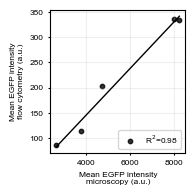

In [16]:
# --- Correlation Plate eGFP levels (flow cytometry) and eGFP levels from imaging (microscope) ---
# calculate mean eGFP levels per clone from microscopy data
df_gfp_live = df_burst[['unique_id', 'clone', 'mean_gfp']].drop_duplicates().dropna().groupby('clone')[
    'mean_gfp'].describe()

# calculate correlation between flow cytometry and microscopy data
common_index = df_gfp_live.index.intersection(df_facs_plate['clone'])
df_gfp_live_comp = df_gfp_live.loc[common_index]
df_facs_plate_comp = df_facs_plate[df_facs_plate['clone'].isin(common_index)]
r2 = stats.pearsonr(df_gfp_live_comp['mean'], df_facs_plate_comp['Mean'])[0] ** 2

fig, ax = plt.subplots(figsize=(45*mm, 45*mm))
sns.regplot(df_gfp_live_comp['mean'], df_facs_plate_comp['Mean'], ci=None, color='black',
            label=f'R$^2$={round(r2, 2)}', scatter_kws={'s': 10}, line_kws={'linewidth': 1})
plt.xlabel('Mean EGFP intensity\nmicroscopy (a.u.)')
plt.ylabel('Mean EGFP intensity\nflow cytometry (a.u.)')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'GFP_Correlation-facsplate-microscopy.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Figure 2
Plots are constructed in a way that they can be used for on/off or size/amplitude analysis.
For linear scale in supplement, comment/uncomment one line in plot code

The schematic in the Figure can be plotted with a different script: 'Plotted_examples_intensitytraces.py'

/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert t

33.5
18.5
15.0
14.0


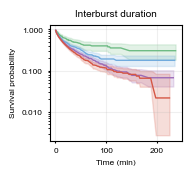

In [17]:
# - On or Off time -
signal = False # True for on-time, False for off-time
measure = "on" if signal == True else "off"
title_plot = 'Burst duration' if signal == True else 'Interburst duration'
# chose off times with at least one burst in trace
df_signallength_times = df_signallength_KM[df_signallength_KM[datatype] == signal]

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(44*mm, 40*mm))
for color_id, clone in enumerate(clones_fit):
    kmf.fit((df_signallength_times[(df_signallength_times['clone'] == clone)]['framecount']/2),
            event_observed=df_signallength_times[(df_signallength_times['clone'] == clone)]['censored'],
            label=clone)
    print(kmf.median_survival_time_)
    km_times = kmf.survival_function_.index.values
    km_survival_probs = kmf.survival_function_[clone].values
    km_survival_probs[km_survival_probs == 0] = np.nan
    km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
    km_ci_lower[km_ci_lower == 0] = np.nan
    km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
    km_ci_upper[km_ci_upper == 0] = np.nan
    ax.plot(km_times[1:], km_survival_probs[1:], color=colors_clones_fit[color_id], label=clone, linewidth=1)
    ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=colors_clones_fit[color_id], alpha=0.2)
#plt.legend()
plt.yscale('log') # comment if you want linear scale
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.title(title_plot)
plt.xlabel('Time (min)')
plt.ylabel('Survival probability')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'{measure}-times_KM.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

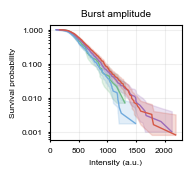

In [18]:
# - Burst size or amplitude -
# define what metric to use (sum (burst size) or max intensity(burst amplitude)
metric = 'corr_tracemax'  # corr_tracemax or corr_tracesum
measure = "size" if metric == 'corr_tracesum' else "amplitude"

# calculate confidence interval using bootstrapping
confidence_interval = []
for clone in clones_fit:
    # calculate cdf and survival function
    cdf = df_signallength_dropedge[
        (df_signallength_dropedge[datatype] == True) & (df_signallength_dropedge['clone'] == clone)][
        metric].value_counts(
        normalize=True).sort_index().cumsum()
    cdf.reset_index()
    survival = 1 + cdf.iloc[0] - cdf

    # Number of bootstrap samples
    num_samples = 10000  # You can adjust this as needed

    # Create an array to store the bootstrapped CDF values
    bootstrap_survivals = np.zeros((num_samples, len(survival)))
    # Perform bootstrapping
    for i in range(num_samples):
        # Resample with replacement from your original data
        bootstrap_sample = np.random.choice(survival.index, size=len(survival), replace=True)

        # Calculate the CDF of the bootstrap sample
        bootstrap_survival = pd.Series(bootstrap_sample).value_counts(normalize=True).sort_index().cumsum()
        bootstrap_survival = 1 + bootstrap_survival.iloc[0] - bootstrap_survival

        # Interpolate the bootstrap CDF to match the original CDF indices
        bootstrap_survival = np.interp(survival.index, bootstrap_survival.index, bootstrap_survival.values)
        bootstrap_survivals[i, :] = bootstrap_survival

    # Calculate the confidence intervals
    alpha = 0.05  # Confidence level (e.g., 95% confidence interval)
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100

    lower_bound = np.percentile(bootstrap_survivals, lower_percentile, axis=0)
    upper_bound = np.percentile(bootstrap_survivals, upper_percentile, axis=0)

    df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df['clone'] = clone
    confidence_interval.append(df)
confidence_interval = pd.concat(confidence_interval)

# plot
fig, ax = plt.subplots(figsize=(44*mm, 40*mm))
for id, clone in enumerate(clones_fit):
    cdf = df_signallength_dropedge[
        (df_signallength_dropedge[datatype] == True) & (df_signallength_dropedge['clone'] == clone)][
        metric].value_counts(normalize=True).sort_index().cumsum()
    survival = 1 + cdf.iloc[0] - cdf
    plt.plot(survival, color=colors_clones_fit[id], linewidth=1)
    plt.fill_between(survival.index, confidence_interval[confidence_interval['clone'] == clone]['lower_bound'],
                     confidence_interval[confidence_interval['clone'] == clone]['upper_bound'], alpha=0.2,
                     color=colors_clones_fit[id])
plt.yscale('log') # comment if you want linear scale
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
plt.grid(alpha=0.2)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.title(f'Burst {measure}')
plt.xlabel('Intensity (a.u.)')
plt.ylabel('Survival probability')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'burst_{measure}.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Supplement 2
Linear scale for Figure 2, see above
Here Fraction of non-bursting cells and manual annotated comparision

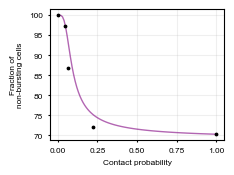

In [19]:
# --- Fraction of non-bursting cells ---
percentage_df = df_burst.copy()
percentage_df = percentage_df.groupby(['unique_id']).first().groupby('clone')['bursting'].value_counts().unstack(
    fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100
percentage_df = percentage_df.merge(df_positions[['clone', 'distance', 'cp']], on='clone')
percentage_df.set_index('clone', inplace=True)

# scale trendline
df_trendline_scaled = df_trendline.copy()
min_value, min_cp = percentage_df.loc['6G3', [False, 'cp']].values
max_value, max_cp = percentage_df.loc['5G7', [False, 'cp']].values
min_original = \
    df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == round(min_cp, 2), df_trendline_scaled.columns[1]].values[
        0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b

# plotting percentage of cells bursting
plt.figure(figsize=(55*mm, 40*mm))
plt.scatter(percentage_df['cp'], percentage_df[False], color='black', zorder=3, s=3)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', linewidth=1, alpha=0.6, zorder=2)
plt.grid(alpha=0.2, zorder=1)
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.tick_params(axis='both', which='both', length=1.5)
plt.xlabel('Contact probability')
plt.ylabel('Fraction of\nnon-bursting cells')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'percentage_bursting_trendline.pdf'), bbox_inches='tight',
            transparent=True)
plt.show()
plt.close()

## Manual annotated comparison

In [24]:
# load data and process for comparsion
path_annotated_data = '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/live_imaging/benchmarking/annotated_tracks/306KI-ddCTCF-dpuro-MS2-HaloMCP-E10Mobi_JF549_30s_fiveclone_manualannotated_combined.csv'


df_annotated = pd.read_csv(path_annotated_data)
df_annotated['detectiontype'] = 'annotated'
# I annotated some 5E10 data, but not enough to show for the paper, hence remove it
df_annotated = df_annotated[df_annotated['clone'] != '5E10']
# also remove single positives to have a fair comparison
df_annotated['spotdetected_filtered_curated'] = df_annotated.groupby('unique_id').apply(
    lambda cell: remove_positives(cell.spotdetected, area_size=2)).reset_index(level=0, drop=True)

# merge annotated data with data from pipeline, only keep movies where both are available
clones = ['5G7', '5F11']
df = df_burst[df_burst['clone'].isin(clones)].reset_index(drop=True)
df['detectiontype'] = 'pipeline'
df_pipeline_sub = df_burst[df_burst['filename'].isin(df_annotated['filename'].unique())]
df_pipeline_sub['detectiontype'] = 'pipeline_subset'

df = pd.concat([df_annotated, df_pipeline_sub, df], ignore_index=True)

# some preprocessing, as above exclude first hour and some manually excluded cells
datatype = 'spotdetected_filtered_curated'

df = df[df['frame'] >= 120]
df = df[df['frame'] <= 600]
df = df[df['spotdetected_filtered_curated'].notna()]

#  statistics for survival probs
# sum-up length of states
df_signallength_comp = df.groupby(['unique_id', 'detectiontype', 'clone'], group_keys=True).apply(signallength,
                                                                                             column=datatype).reset_index(level=['detectiontype', 'clone']).reset_index(drop=True)
# Indicate which values are incomplete/censored
df_signallength_comp = df_signallength_comp.groupby(['unique_id', 'detectiontype', 'clone'], group_keys=True).apply(
    indicate_first_last, column='signal_no').reset_index(drop=True)

# For KM drop left censored and non-bursting
df_km = df_signallength_comp[df_signallength_comp.censored != 'leftcensored']
df_km = df_km[df_km.censored != 'nonbursting']
# keep right censored and non-censored
df_km.loc[df_km['censored'] == 'rightcensored', 'censored'] = 0
df_km.loc[df_km['censored'] == 'noncensored', 'censored'] = 1

# For size and amplitude drop left censored and non-bursting
df_sizeamp = df_signallength_comp[df_signallength_comp.censored != 'leftcensored']
df_sizeamp = df_sizeamp[df_sizeamp.censored != 'rightcensored']
df_sizeamp = df_sizeamp[df_sizeamp.censored != 'nonbursting']

/var/folders/xw/97j8jgvs0jj4vght5r2xkt1h0000gp/T/ipykernel_29278/3363026863.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pipeline_sub['detectiontype'] = 'pipeline_subset'
/var/folders/xw/97j8jgvs0jj4vght5r2xkt1h0000gp/T/ipykernel_29278/3363026863.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df_annotated, df_pipeline_sub, df], ignore_index=True)


/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/janatunnermann/miniconda3/envs/MS2analysis/lib/python3.10/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert t

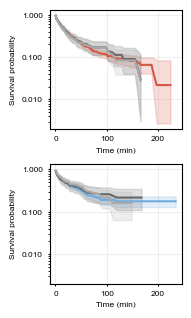

In [25]:
# KM on or off time
signal = False # True for on-time, False for off-time
df_km_times = df_km[df_km[datatype] == signal]

kmf = KaplanMeierFitter()

# compare annotated and pipeline
signal_type = 'on' if signal else 'off'

fig, axs = plt.subplots(2, 1, figsize=(44*mm, 2 * 1.5), sharey=True, sharex=True)
for i, ax in enumerate(axs.ravel()):
    clone = clones[i]
    color_clone = colors_clones_fit[3] if clone == '5G7' else colors_clones_fit[1]
    color_id = [color_clone, 'dimgrey', 'darkgrey']
    for j, detection_type in enumerate(['pipeline', 'pipeline_subset', 'annotated']):
        kmf.fit((df_km_times[(df_km_times['detectiontype'] == detection_type) & (df_km_times['clone'] == clone)][
                     'framecount'] / 2),
                event_observed=
                df_km_times[(df_km_times['detectiontype'] == detection_type) & (df_km_times['clone'] == clone)][
                    'censored'])
        km_times = kmf.survival_function_.index.values
        km_survival_probs = kmf.survival_function_.values
        km_survival_probs[km_survival_probs == 0] = np.nan
        km_ci_lower = kmf.confidence_interval_.iloc[:, 0].values
        km_ci_lower[km_ci_lower == 0] = np.nan
        km_ci_upper = kmf.confidence_interval_.iloc[:, 1].values
        km_ci_upper[km_ci_upper == 0] = np.nan
        ax.plot(km_times[1:], km_survival_probs[1:], color=color_id[j], label=detection_type)
        ax.fill_between(km_times[1:], km_ci_lower[1:], km_ci_upper[1:], color=color_id[j], alpha=0.2)
    ax.tick_params('x', labelbottom=True)
    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Time (min)')
    ax.grid(alpha=0.2)
    ax.tick_params(axis='both', which='both', length=1.5)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    # ax.legend()
    # limit = ax.get_ylim()
# plt.ylim(bottom=limit[0])
plt.tight_layout(pad=0.1)
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(path_out, f'{signal_type}times_comparision.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

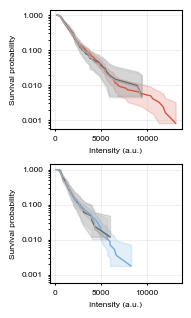

In [26]:
# burst size or amplitude
metric = 'corr_tracesum'  # corr_tracemax or corr_tracesum
clones = ['5G7', '5F11']
detection_type = ['pipeline', 'pipeline_subset', 'annotated']
metric_type = 'size' if 'sum' in metric else 'amplitude'

# calculate confidence interval using bootstrapping
confidence_interval = []
for clone, detectiontype in itertools.product(clones, detection_type):
    # calculate cdf and survival function
    cdf = df_sizeamp[
        (df_sizeamp[datatype] == True) & (df_sizeamp['clone'] == clone) & (
                    df_sizeamp['detectiontype'] == detectiontype)][
        metric].value_counts(
        normalize=True).sort_index().cumsum()
    cdf.reset_index()
    survival = 1 + cdf.iloc[0] - cdf

    # Number of bootstrap samples
    num_samples = 10000  # You can adjust this as needed

    # Create an array to store the bootstrapped CDF values
    bootstrap_survivals = np.zeros((num_samples, len(survival)))
    # Perform bootstrapping
    for i in range(num_samples):
        # Resample with replacement from your original data
        bootstrap_sample = np.random.choice(survival.index, size=len(survival), replace=True)

        # Calculate the CDF of the bootstrap sample
        bootstrap_survival = pd.Series(bootstrap_sample).value_counts(normalize=True).sort_index().cumsum()
        bootstrap_survival = 1 + bootstrap_survival.iloc[0] - bootstrap_survival

        # Interpolate the bootstrap CDF to match the original CDF indices
        bootstrap_survival = np.interp(survival.index, bootstrap_survival.index, bootstrap_survival.values)
        bootstrap_survivals[i, :] = bootstrap_survival

    # Calculate the confidence intervals
    alpha = 0.05  # Confidence level (e.g., 95% confidence interval)
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100

    lower_bound = np.percentile(bootstrap_survivals, lower_percentile, axis=0)
    upper_bound = np.percentile(bootstrap_survivals, upper_percentile, axis=0)

    df = pd.DataFrame({'lower_bound': lower_bound, 'upper_bound': upper_bound})
    df['clone'] = clone
    df['detection_type'] = detectiontype
    confidence_interval.append(df)
confidence_interval = pd.concat(confidence_interval)

# plot
fig, axs = plt.subplots(2, 1, figsize=(44*mm, 2 * 1.5), sharey=True, sharex=True)
for i, ax in enumerate(axs.ravel()):
    clone = clones[i]
    color_clone = colors_clones_fit[3] if clone == '5G7' else colors_clones_fit[1]
    color_id = [color_clone, 'dimgrey', 'darkgrey']
    for j, detection_type in enumerate(['pipeline', 'pipeline_subset', 'annotated']):
        cdf = df_sizeamp[
            (df_sizeamp[datatype] == True) & (df_sizeamp['clone'] == clone) & (
                        df_sizeamp['detectiontype'] == detection_type)][
            metric].value_counts(normalize=True).sort_index().cumsum()
        survival = 1 + cdf.iloc[0] - cdf
        ax.plot(survival, linewidth=1, label=detection_type, color=color_id[j])
        ax.fill_between(survival.index, confidence_interval[
            (confidence_interval['clone'] == clone) & (confidence_interval['detection_type'] == detection_type)][
            'lower_bound'],
                        confidence_interval[(confidence_interval['clone'] == clone) & (
                                    confidence_interval['detection_type'] == detection_type)]['upper_bound'], alpha=0.2,
                        color=color_id[j])
    ax.tick_params('x', labelbottom=True)
    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Intensity (a.u.)')
    ax.grid(alpha=0.2)
    ax.tick_params(axis='both', which='both', length=1.5)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    # ax.legend()
plt.tight_layout(pad=0.1)
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(path_out, f'burst{metric_type}_comparision.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Figure 3

In [27]:
# Burst frequency and CV calculation
df_signalcount = df_signallength[['unique_id', datatype]].groupby('unique_id').value_counts().reset_index()
df_signalcount.columns = ['unique_id', datatype, 'no_of_events']
df_signalcount['clone'] = df_signalcount['unique_id'].map(df_burst.groupby(['unique_id'])['clone'].first())
df_signalcount['track_length'] = df_signalcount['unique_id'].map(df_burst.groupby(['unique_id']).size())

# calculate burst frequency
df_burstfrequency = df_signalcount.sort_values(by=datatype, ascending=False)
df_burstfrequency = df_burstfrequency.drop_duplicates(subset='unique_id')
# select rows where spotdetected curated is false and set no_of_events to 0
df_burstfrequency.loc[df_burstfrequency[df_burstfrequency[datatype] == False].index, 'no_of_events'] = 0
df_burstfrequency['burst_frequency_perh'] = df_burstfrequency['no_of_events'] / (
        df_burstfrequency['track_length'] / 120)

df_burstfrequency_avg = df_burstfrequency.groupby('clone')['burst_frequency_perh'].describe().reset_index()
df_burstfrequency_avg = df_burstfrequency_avg.merge(df_positions[['clone', 'distance', 'cp']], on='clone', how='left')
df_burstfrequency_avg = df_burstfrequency_avg.merge(colors_clones_all)

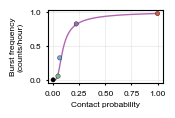

In [28]:
# Plot burst frequency with trendline
# scale trend-line to min and max value from my experiment (maybe fit instead?)
df_trendline_scaled = df_trendline.copy()
min_value, min_cp = df_burstfrequency_avg.loc[df_burstfrequency_avg['clone'] == '6G3', ['mean', 'cp']].values[0]
max_value, max_cp = df_burstfrequency_avg.loc[df_burstfrequency_avg['clone'] == '5G7', ['mean', 'cp']].values[0]
min_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0, df_trendline_scaled.columns[1]].values[0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b

# plot burst frequency and cp
plt.figure(figsize=(1.57, 1))
plt.scatter(df_burstfrequency_avg['cp'], df_burstfrequency_avg['mean'], color=df_burstfrequency_avg['color'], edgecolor ='black', linewidths=0.25, zorder=3, s=10)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', alpha=0.6, linewidth=1, zorder=1)
plt.grid(alpha=0.2, zorder=0)
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.tick_params(axis='both', which='both', length=1.5)
plt.xlabel('Contact probability')
plt.ylabel('Burst frequency\n(counts/hour)')
plt.tight_layout(pad=0.1)
axes = plt.gca()
x_limits = axes.get_xlim()
plt.savefig(os.path.join(path_out, 'burstfreq_trendline_colored.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

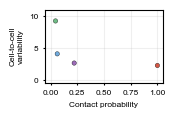

In [29]:
# plot cv burst frequency
plt.figure(figsize=(1.57, 1))
df_burstfrequency_avg['cv'] = df_burstfrequency_avg['std'] / df_burstfrequency_avg['mean']
plt.scatter(df_burstfrequency_avg['cp'], df_burstfrequency_avg['cv'], color=df_burstfrequency_avg['color'], edgecolor ='black', linewidths=0.25, zorder=3, s=10)
plt.grid(alpha=0.2, zorder=1)
plt.xlabel('Contact probability')
plt.ylabel('Cell-to-cell\nvariability')
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.ylim(-0.5, 11)
plt.xlim(x_limits)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'cv_burstfreq.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

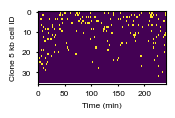

In [30]:
# Kymograph of spotdetected per clone
selected_clone = '5G7' # either 5G7 or 5F11
distance = '5 kb' if selected_clone == '5G7' else '149 kb'
df_clone = df_burst[(df_burst['clone'] == selected_clone)]
# only select long traces
df_clone = df_clone.groupby('unique_id').filter(lambda x: x.frame.count() >= 480)

kymograph = df_clone.pivot(index='unique_id', columns='frame', values='spotdetected_filtered_curated')
kymograph.dropna(axis=0, how='all', inplace=True)
kymograph = kymograph.fillna(5).astype(int)
kymograph.replace(5, np.nan, inplace=True)

# sort based on number of bursts
kymograph['count_ones'] = kymograph.sum(axis=1)
kymograph = kymograph.sort_values(by='count_ones', ascending=False)
kymograph = kymograph.drop(columns='count_ones')

plt.figure(figsize=(40*mm, 25.5*mm))
plt.imshow(kymograph, cmap='viridis', aspect='auto', interpolation='none')
x_ticks = np.arange(0, kymograph.shape[1], 100).astype(int)
plt.xticks(x_ticks, (x_ticks / 2).astype(int))
plt.tick_params(axis='both', which='both', length=1.5)
plt.grid(False)
plt.ylabel(f'Clone {distance} cell ID')
plt.xlabel('Time (min)')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'kymograph_{selected_clone}.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# Supplement 3

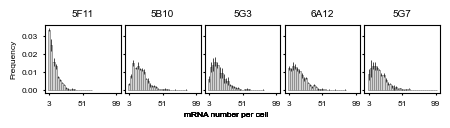

In [39]:
# Histogramm of no. mRNA per cell, split in low and high expressing clones to adjust for y-axis
# Plot eithr high or low expressing cells
clones_low = ['E14ddCTCF', '6G3', '5E10']
clones_high = ['5F11', '5B10', '5G3', '6A12', '5G7']
chosen_clones = clones_high

if chosen_clones == clones_low:
    category_clones = 'low'
else:
    category_clones = 'high'
grouped_clone = df_fish_avgcell[df_fish_avgcell['clone'].isin(chosen_clones)].groupby(['clone'])

bin_width = 3
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(110 * mm, 25 * mm), sharex=True, sharey=True)
# Flatten the 2D array of subplots to a 1D array
axes = axes.flatten()
for i, name in enumerate(chosen_clones):
    if name in grouped_clone.groups:
        group = grouped_clone.get_group(name)
    ax = axes[i]
    bins = np.arange(group['spots_per_cell'].min(), group['spots_per_cell'].max() + bin_width, bin_width)
    # Calculate histograms for each date for getting errorbars
    grouped_date = group.groupby('date')
    histograms_date = []
    for date, date_group in grouped_date:
        counts, _ = np.histogram(date_group['spots_per_cell'], bins=bins, density=False)
        histograms_date.append(counts)
    histograms_date = np.array(histograms_date)
    # Calculate mean and std dev for each bin
    mean_counts = histograms_date.mean(axis=0)
    std_counts = histograms_date.std(axis=0)
    # Convert counts to densities
    bin_areas = np.diff(bins) * len(group)
    densities = mean_counts / bin_areas
    density_errors = std_counts / bin_areas
    # Plot the bar plot with error bars as densities
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Get bin centers
    ax.bar(bin_centers, densities, width=bin_width, yerr=density_errors, capsize=0,
           color='lightgray', edgecolor='gray', linewidth=0.5, error_kw={'elinewidth': 0.5})
    ax.set_title(f'{name}')
    #ax.set_xlabel('mRNA number per cell')
    # ax.set_xlim(-4.95, 103.95)
    if i == 0:
        ax.set_ylabel('Frequency')
    ax.tick_params(axis='both', which='both', length=1.5)
    x_ticks = [bin_centers[0], bin_centers[-1], bin_centers[len(bin_centers) // 2]]
    x_ticks_labels = [bins[1], bins[-1], bins[len(bins) // 2]]
    plt.xticks(x_ticks, x_ticks_labels)
    fig.text(0.5, -0.1, 'mRNA number per cell', ha='center')
if chosen_clones == clones_low:
    for i in [3, 4]:
        fig.delaxes(axes[i])

plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, f'FISH_hist_clones_{category_clones}.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

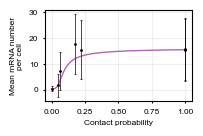

In [42]:
# Mean mRNA as function of cp
df_fish_avg = df_fish_avgcell.groupby('clone')['spots_per_cell'].describe().reset_index()
df_fish_avg = df_fish_avg.merge(df_positions[['clone', 'distance', 'cp']], on='clone')

# scale trend-line to min and max value from my experiment (maybe fit instead?)
df_trendline_scaled = df_trendline.copy()
min_value, min_cp = df_fish_avg.loc[df_fish_avg['clone'] == '6G3', ['mean', 'cp']].values[0]
max_cp = 1
max_value = df_fish_avg.loc[df_fish_avg['cp'] == max_cp, ['mean']].mean().values[0]
min_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0, df_trendline_scaled.columns[1]].values[0]
max_original = df_trendline_scaled.loc[df_trendline_scaled.iloc[:, 0] == 0.99, df_trendline_scaled.columns[1]].values[0]
m = (max_value - min_value) / (max_original - min_original)
b = min_value - m * min_original
df_trendline_scaled['y_scaled'] = m * df_trendline_scaled.iloc[:, 1] + b

# plot mean mrna per cell - cp
plt.figure(figsize=(47* mm, 30 * mm))
plt.errorbar(df_fish_avg['cp'], df_fish_avg['mean'], yerr=df_fish_avg['std'], fmt="o", color='black', markersize=1,
             capsize=1,  # Size of the error bar caps
             capthick=0.5,  # Thickness of the error bar caps
             elinewidth=0.5)
plt.plot(df_trendline_scaled[0], df_trendline_scaled['y_scaled'], color='purple', alpha=0.6, linewidth=1)
plt.grid(alpha=0.2)
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Contact probability')
plt.ylabel('Mean mRNA number\nper cell')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'FISH_trendline.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [48]:
# bit pre-processing for correlation plots
df_fish_avg = df_fish_avgcell.groupby('clone')['spots_per_cell'].describe()
df_facs_exp_avg = df_facs_exp.groupby('Clone')['Mean'].describe()
df_burstfrequency_avg.set_index('clone', inplace=True)
df_facs_plate.set_index('clone', inplace=True)

KeyError: "None of ['clone'] are in the columns"

0.8443189890300958


/Users/janatunnermann/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


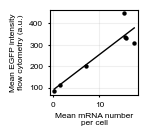

In [49]:
# Comparison - mean mRNA count and protein level flow cytometry
common_index = df_fish_avg.index.intersection(df_facs_plate.index)
df_fish_avg_com = df_fish_avg.loc[common_index]
df_facs_plate_com = df_facs_plate.loc[common_index]
r2 = stats.pearsonr(df_fish_avg_com['mean'], df_facs_plate_com['Mean'])[0] ** 2
print(r2)

fig, ax = plt.subplots(figsize=(33 * mm, 30 * mm))
sns.regplot(df_fish_avg_com['mean'], df_facs_plate_com['Mean'], ci=None, color='black',
            label=f'R$^2$={round(r2, 2)}', scatter_kws={'s': 10, 'linewidths': 0, 'alpha': 1, 'zorder': 2},
            line_kws={'linewidth': 1, 'zorder': 3})
plt.xlabel('Mean mRNA number\nper cell')
plt.ylabel('Mean EGFP intensity\nflow cytometry (a.u.)')
# plt.legend(loc='lower right')
plt.grid(alpha=0.2, zorder=1)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'corr_plate_mRNA.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

0.9795620687669168


/Users/janatunnermann/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


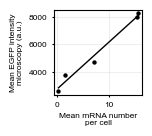

In [50]:
# Comparison - mean mRNA count and protein level microscopy
common_index = df_fish_avg.index.intersection(df_gfp_live.index)
df_fish_avg_com = df_fish_avg.loc[common_index]
df_gfp_live_com = df_gfp_live.loc[common_index]
r2 = stats.pearsonr(df_fish_avg_com['mean'], df_gfp_live_com['mean'])[0] ** 2
print(r2)

fig, ax = plt.subplots(figsize=(34 * mm, 30 * mm))
sns.regplot(df_fish_avg_com['mean'], df_gfp_live_com['mean'], ci=None, color='black',
            label=f'R$^2$={round(r2, 2)}', scatter_kws={'s': 10, 'linewidths': 0, 'alpha': 1, 'zorder': 2},
            line_kws={'linewidth': 1, 'zorder': 3})
plt.xlabel('Mean mRNA number\nper cell')
plt.ylabel('Mean EGFP intensity\nmicroscopy (a.u.)')
# plt.legend(loc='lower right')
plt.grid(alpha=0.2, zorder=1)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'corr_proteinmicroscopy_mRNA.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

/Users/janatunnermann/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


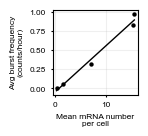

In [51]:
# Comparison - mean mRNA count and protein level
# burst frequency and FISH data
common_index = df_fish_avg.index.intersection(df_burstfrequency_avg.index)
df_fish_avg_com = df_fish_avg.loc[common_index]
df_burstfrequency_avg_com = df_burstfrequency_avg.loc[common_index]
r2 = stats.pearsonr(df_fish_avg_com['mean'], df_burstfrequency_avg_com['mean'])[0] ** 2

fig, ax = plt.subplots(figsize=(33 * mm, 30 * mm))
sns.regplot(df_fish_avg_com['mean'], df_burstfrequency_avg_com['mean'], ci=None, color='black',
            label=f'R$^2$={round(r2, 2)}', scatter_kws={'s': 10, 'linewidths': 0, 'alpha': 1, 'zorder': 2},
            line_kws={'linewidth': 1, 'zorder': 3})
plt.xlabel('Mean mRNA number\nper cell')
plt.ylabel('Avg burst frequency\n(counts/hour)')
# plt.legend(loc='lower right')
plt.grid(alpha=0.2, zorder=1)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'corr_burstfreq_mRNA.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

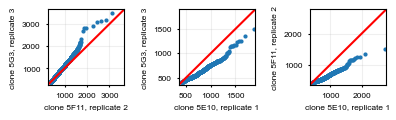

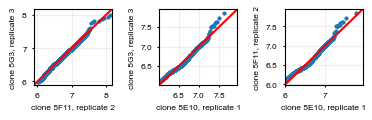

In [56]:
# QQ plots for before and after z-score normalisation
df_qq = df_fish_TS.dropna(subset=['zscore'])
samples = ['202309215G3', '202309205F11', '202309145E10']
samples_names = [
    sub.replace('202309215G3', 'clone 5G3, replicate 3').replace('202309205F11', 'clone 5F11, replicate 2').replace(
        '202309145E10', 'clone 5E10, replicate 1') for sub in samples]
sample_combinations = list(itertools.combinations(samples, 2))
sample_combinations_names = list(itertools.combinations(samples_names, 2))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(96*mm , 26*mm))
axes = axes.flatten()
for combination, name in zip(sample_combinations, sample_combinations_names):
    ax = axes[sample_combinations.index(combination)]
    sm.qqplot_2samples(df_qq[df_qq['sample'] == combination[0]]['spot_max'],
                       df_qq[df_qq['sample'] == combination[1]]['spot_max'], line='45', ax=ax)
    for line in ax.get_lines():
        line.set_markersize(2)
    ax.set_ylabel(f'{name[0]}')
    ax.set_xlabel(f'{name[1]}')
    ax.grid(alpha=0.2)
    ax.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1, w_pad=2)
plt.savefig(os.path.join(path_out, f'QQ-plots_example_before.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

# example QQ plots for corrected zscores
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(90*mm , 26*mm))
axes = axes.flatten()
for combination, name in zip(sample_combinations, sample_combinations_names):
    ax = axes[sample_combinations.index(combination)]
    sm.qqplot_2samples(df_qq[df_qq['sample'] == combination[0]]['zscore'],
                       df_qq[df_qq['sample'] == combination[1]]['zscore'], line='45', ax=ax)
    for line in ax.get_lines():
        line.set_markersize(2)
    ax.set_ylabel(f'{name[0]}')
    ax.set_xlabel(f'{name[1]}')
    ax.grid(alpha=0.2)
    ax.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1, w_pad=2)
plt.savefig(os.path.join(path_out, f'QQ-plots_example_after.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

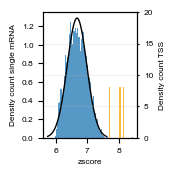

In [10]:
# CGroundtruth data with gaussian fit and threshold for TSS classification
fig, ax1 = plt.subplots(figsize=(1.57, 1.57))
sns.histplot(df_fish_TS_groundtruth[df_fish_TS_groundtruth['TS_groundtruth'] == 'singlemRNA'],
             x='zscore', bins=100, stat='density', ax=ax1, label='singlemRNA', edgecolor=None, zorder=2)
ax1.plot(x_tss, stats.norm.pdf(x_tss, mu_tss, sigma_tss), label='Gaussian fit', color='black', linewidth=1, zorder=3)
# Create a second y-axis that shares the same x-axis
ax1.set_ylabel('Density count single mRNA')
ax2 = ax1.twinx()
sns.histplot(df_fish_TS_groundtruth[df_fish_TS_groundtruth['TS_groundtruth'] == 'TS'],
             x='zscore', bins=100, stat='density', color='orange', ax=ax2, label='TS', edgecolor=None,  zorder=2)
ax2.set_ylim(0, 20)
ax2.set_ylabel('Density count TSS')
# create single legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
# ax1.legend(handles, labels, loc='upper right')
plt.xlabel('corrected zscore')
plt.grid(alpha=0.2, zorder=0)
plt.tick_params(axis='both', which='both', length=1.5)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'FISH_groundtruthfitTS.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

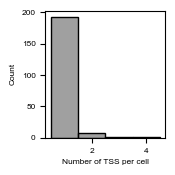

In [11]:
# number of RNA per TS
ts_percell = df_fish_TS.groupby(['file', 'label'])['calledTS'].value_counts().rename('number').reset_index()
fig, ax = plt.subplots(figsize=(1.57, 1.57))
sns.histplot(ts_percell[ts_percell['calledTS'] == True], x='number', discrete=True, color='gray')
plt.xlabel('Number of TSS per cell')
plt.ylabel('Count')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'histogramm_numberTS.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

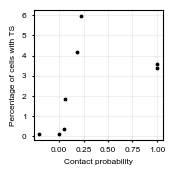

In [12]:
# percentage of cells with TS
ts_percCells = pd.read_csv(
    '/Volumes/ggiorget_scratch/Jana/transcrip_dynamic/E10_Mobi/fish/summarized_data/perc-cell.csv')
ts_percCells = ts_percCells.merge(df_positions[['clone', 'distance', 'cp']], on='clone', how='left')
ts_percCells.fillna(-0.2, inplace=True)

plt.figure(figsize=(1.57, 1.57))
plt.scatter(ts_percCells['cp'], ts_percCells['perc'], s=3, zorder=2, color='black')
plt.grid(alpha=0.2, zorder=1)
x_ticks = np.linspace(0, 1, 5)
plt.xticks(x_ticks)
plt.tick_params(axis='both', which='both', length=1.5)  # Adjust tick length
plt.xlabel('Contact probability')
plt.ylabel('Percentage of cells with TSS')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'FISH_percTS.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

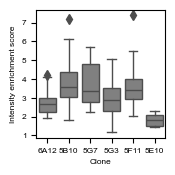

In [13]:
# intensity enrichment in TS
selected_enrichment = df_fish_TS[(df_fish_TS['calledTS'] == True) & (~df_fish_TS['clone'].isin(['6G3', 'E14ddCTCF']))]

plt.figure(figsize=(1.57, 1.57))
sns.boxplot(data=selected_enrichment, x='clone', y='enrichment', color='gray', linewidth=1)
plt.ylabel('Intensity enrichment score')
plt.xlabel('Clone')
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(path_out, 'FISH_enrichment.pdf'), bbox_inches='tight', transparent=True)
plt.show()
plt.close()